In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,CuDNNLSTM,Flatten,CuDNNGRU, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional,GlobalMaxPool2D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc
from sklearn.model_selection import train_test_split
import itertools
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.losses import CategoricalCrossentropy

C:\Users\Tarik\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('preprocessed.csv')
df = df[['Posts', 'Label']]

In [3]:
df 

,Posts,Label
0,እነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደረ...,ነጻ
1,ጃዋር አልበግዳዲ በግርግር ስልጣን ለመያዝ የሚያደርገው ነገር ብዙ ስራ ፈ...,ጥላቻ
2,ምን ሆናችሁ ኦርቶዶክሶች ሰሞኑን ፖለቲካ ገባ እንዴ ውስጣችኋይዟችሁ ወደ...,ነጻ
3,ስለ አሳምነው የምትፅፈው ነገር አሳምነው ለአማራ የነበረው ተቆርቋሪነት አ...,ነጻ
4,አጋጣሚውን ተጠቅመው የእስክንድር ነጋን ስም እና ትግል ለማዳከም የሚፈልጉ...,ጥላቻ
...,...,...
5725,ኦህዴድ እራሱ ባመጣዉ ቀዉስ ተናዉጦ መዉጫ ቀዳዳ እየፈለገ ነዉ,ጥላቻ
5726,ኦሮሞ ሀገር መምራት አይችልም,ጥላቻ
5727,ሲማረኩ በሚሰጡት አትታለሉ ማርኮ ከማብላት መረሸን ይቀላል ትግሬ ጎረ...,ጥላቻ
5728,በኦሮሞ ጥላቻ የተሞሉ ሴገጤዎች የወሎ ኦሮሞን ምንም ስሌ የማያውቅን ህ...,ጥላቻ


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.Posts, df.Label, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 4584
# Test data samples: 1146


In [6]:
max_features = 10000 # hyperparamenter
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

In [7]:
MAX_LEN = max(df['Posts'].apply(lambda x: len(x.split(' '))))
print("Maximum sentence length of the dataset:", MAX_LEN)

Maximum sentence length of the dataset: 215


In [8]:
X_t = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
X_te = pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [9]:
X_t

array([[   0,    0,    0, ...,   69,  308,    1],
       [   0,    0,    0, ..., 8300, 8301, 8302],
       [   0,    0,    0, ..., 8318,  859, 8319],
       ...,
       [   0,    0,    0, ..., 3083, 2243, 1447],
       [   0,    0,    0, ...,   42,   24,    1],
       [   0,    0,    0, ..., 1300,   31,  529]])

In [10]:
pretrained_model ='fasttext'
#pretrained_model ='word2vec'

In [11]:
if pretrained_model == "fasttext":
    EMBEDDING_FILE='Embeddings/cc.am.300.vec'
    gc.enable()
    # def loadEmbeddingMatrix():
    embeddings_index = dict()
    f = open(EMBEDDING_FILE,encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs #50 dimensions
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))
    gc.collect()
    embed_size = 300 #hyperparamenter
elif pretrained_model == 'word2vec':
    EMBEDDING_FILE = word2vec.KeyedVectors.load_word2vec_format("Embeddings/5w_10ng_am_w2v_cbow_300D.txt", binary=False)
    embed_size = 300
    EMBEDDING_FILE.fill_norms()
    gc.enable()
    embeddings_index = dict()
    for word in EMBEDDING_FILE.key_to_index:
        embeddings_index[word] = EMBEDDING_FILE.word_vec(word)
    #print('Loaded %s word vectors.' % len(embeddings_index))
    gc.collect()

Loaded 304650 word vectors.


In [12]:
embeddings_index = dict(itertools.islice(embeddings_index.items(), 1,len(embeddings_index)))

In [13]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()

nb_words = len(tokenizer.word_index)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
gc.collect()

embeddedCount = 0
for word, i in tokenizer.word_index.items():
    i-=1
    #print(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
        embeddedCount+=1
print('total embedded:',embeddedCount,'common words')

del(embeddings_index)
gc.collect()

total embedded: 16517 common words


0

In [14]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [21]:
def model(model_type = 'GRU'):
    inp = Input(shape=(MAX_LEN, ))
    x = Embedding(len(tokenizer.word_index), embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False)(inp)
    
    if model_type == 'LSTM':
        x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
    elif model_type == 'CNN':
        x = Conv1D(60,32,activation='relu',name='CNN_layer')(x)
    elif model_type == 'GRU':
        x = GRU(60,name='GRU_layer',return_sequences=True)(x)
    elif model_type == 'SimpleRNN':
        x = SimpleRNN(32, return_sequences=True,name='SimpleRNN')(x)
    
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x)

    model.compile(loss=CategoricalCrossentropy(), 
                      optimizer='adam',
                      metrics=['accuracy'])
    model.summary()
    return model

In [22]:
model = model('GRU')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 215)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 215, 300)          7618500   
                                                                 
 GRU_layer (GRU)             (None, 215, 60)           65160     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 flatten_1 (Flatten)         (None, 60)                0         
                                                           

In [19]:
callback = EarlyStopping(monitor='loss', patience=5)

In [23]:
history = model.fit(X_t, y_train_oh,batch_size=128,epochs=100, validation_split=0.1,verbose=1, callbacks=[callback])

Epoch 1/100
33/33 [==============================] - 18s 364ms/step - loss: 0.6869 - accuracy: 0.5467 - val_loss: 0.6777 - val_accuracy: 0.6035
Epoch 2/100
33/33 [==============================] - 12s 356ms/step - loss: 0.6764 - accuracy: 0.5842 - val_loss: 0.6656 - val_accuracy: 0.6187
Epoch 3/100
33/33 [==============================] - 12s 364ms/step - loss: 0.6648 - accuracy: 0.6095 - val_loss: 0.6545 - val_accuracy: 0.6536
Epoch 4/100
33/33 [==============================] - 12s 361ms/step - loss: 0.6524 - accuracy: 0.6276 - val_loss: 0.6427 - val_accuracy: 0.6514
Epoch 5/100
33/33 [==============================] - 12s 353ms/step - loss: 0.6392 - accuracy: 0.6478 - val_loss: 0.6326 - val_accuracy: 0.6580
Epoch 6/100
33/33 [==============================] - 12s 350ms/step - loss: 0.6223 - accuracy: 0.6531 - val_loss: 0.6245 - val_accuracy: 0.6536
Epoch 7/100
33/33 [==============================] - 12s 356ms/step - loss: 0.6117 - accuracy: 0.6555 - val_loss: 0.6343 - val_accuracy:

33/33 [==============================] - 15s 442ms/step - loss: 0.3358 - accuracy: 0.8599 - val_loss: 0.7591 - val_accuracy: 0.6688
Epoch 58/100
33/33 [==============================] - 13s 385ms/step - loss: 0.2964 - accuracy: 0.8698 - val_loss: 0.7842 - val_accuracy: 0.6710
Epoch 59/100
33/33 [==============================] - 12s 369ms/step - loss: 0.2719 - accuracy: 0.8878 - val_loss: 0.9528 - val_accuracy: 0.6732
Epoch 60/100
33/33 [==============================] - 12s 353ms/step - loss: 0.2683 - accuracy: 0.8880 - val_loss: 0.8504 - val_accuracy: 0.6645
Epoch 61/100
33/33 [==============================] - 11s 347ms/step - loss: 0.2621 - accuracy: 0.8878 - val_loss: 0.8353 - val_accuracy: 0.6623
Epoch 62/100
33/33 [==============================] - 13s 381ms/step - loss: 0.2470 - accuracy: 0.8960 - val_loss: 0.9491 - val_accuracy: 0.6536
Epoch 63/100
33/33 [==============================] - 13s 391ms/step - loss: 0.2447 - accuracy: 0.8999 - val_loss: 1.0105 - val_accuracy: 0.671

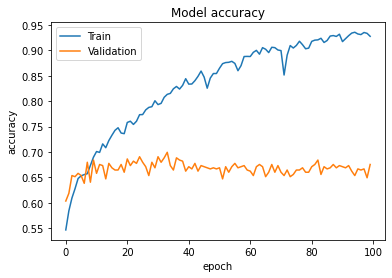

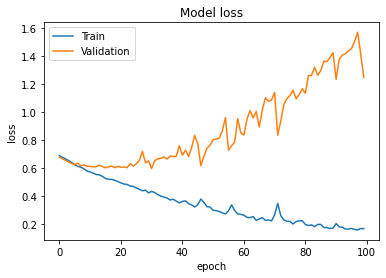

In [24]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.ylabel
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
pred = model.predict(X_te)

36/36 [==============================] - 3s 44ms/step


In [26]:
# list containing original values
original = []
for i in y_test_oh:
    original.append(np.argmax(i))

In [27]:
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [28]:
original[:20]

[1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]

In [29]:
prediction[:20]

[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [30]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,recall_score,f1_score,precision_score 
print('Accuracy: ',accuracy_score(original, prediction))
print('Recall: ',recall_score(original, prediction, average='macro'))
print('Precision: ',precision_score(original, prediction, average='macro'))
print('F1-score: ',f1_score(original, prediction, average='macro'))

Accuracy:  0.6413612565445026
Recall:  0.6382167900002771
Precision:  0.6377928824049515
F1-score:  0.6379647884888104


In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Get the confusion matrix
cf_matrix = confusion_matrix(original, prediction)
print(cf_matrix)

[[423 210]
 [201 312]]


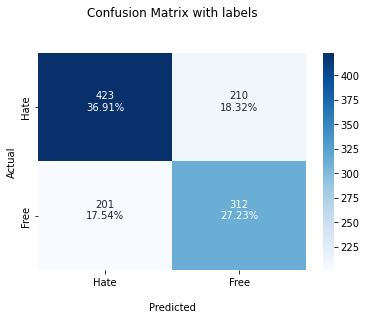

In [34]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n" for v1, v2 in
zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Hate','Free'])
ax.yaxis.set_ticklabels(['Hate','Free'])
## Display the visualization of the Confusion Matrix.
plt.show()